In [1]:
import torch
import numpy as np
# from transformers import pack_seq, LandmarkEnbedding, PositionalEncoding, Net
from transformers import (
    EncoderEmbedding,
    PositionalEncoding,
    LandmarkEnbedding,
    Transformer,
    DecoderEmbedding
)
import matplotlib.pyplot as plt

In [2]:
# transformer parameters = 
# (input_size,
# vocab_size,
# encoder_max_seq_length,
# decoder_max_seq_length,
# embed_dim,
# ffn_hidden,
# num_heads,
# drop_prob,
# num_layers)
model = Transformer(input_size=42, vocab_size=62, max_seq_length=256, embed_dim=256, ffn_hidden=1024, num_heads=4, drop_prob=0.1, num_layers=2)

In [5]:
x = torch.randn(32, 512, 42)
y = torch.randint(0, 62, (32, 512))

In [9]:
loss = torch.nn.CrossEntropyLoss()

In [19]:
preds = torch.randn(1, 3, 15)
targets = torch.randint(0, 3, (1, 15))

In [20]:
loss(preds, targets)

tensor(1.2763)

In [7]:
model(x, y).shape

torch.Size([32, 512, 62])

In [13]:
ee = EncoderEmbedding(256, 42, 512)

In [17]:
de = DecoderEmbedding(256, 63, 512)

In [18]:
enb_enc = ee(x)
enb_dec = de(y)

In [19]:
print(enb_enc.shape)
print(enb_dec.shape)

torch.Size([32, 256, 256])
torch.Size([32, 32, 256])


In [41]:
model(x, y).shape

torch.Size([1, 32, 60])

In [4]:
torch.matmul(a, a.transpose(-1, -2)).shape

torch.Size([2, 3, 3])

In [5]:
a = torch.randn(2, 3, 4)
b = torch.randn(2, 3, 3)

In [8]:
torch.matmul(b, a).shape

torch.Size([2, 3, 4])

In [7]:
seq = [
    torch.randn((10, 21, 2)),
    torch.randn((14, 21, 2)),
    torch.randn((18, 21, 2)),
    torch.randn((18, 21, 2)),
]

In [6]:
x, x_mask = pack_seq(seq)

In [24]:
x.shape

torch.Size([4, 18, 42])

In [25]:
le = LandmarkEnbedding(42, 128)

In [26]:
x_enc = le(x)

In [10]:
x_enc.shape

torch.Size([4, 18, 128])

In [11]:
pe = PositionalEncoding(256, 128)

In [6]:
dic = {'a': 3, 'b': 2}

In [8]:
li = ['a', 'a', 'a', 'b', 'b']

In [9]:
# convert element of li by dic
li = [dic[i] for i in li]

In [10]:
import numpy as np

In [12]:
hand = np.random.rand(12, 543, 2)

In [13]:
hand[5, 52, 1] = np.nan

In [2]:
class cfg:
    max_length = 256

In [5]:
model = Net(cfg)

In [9]:
batch = {'xyz': seq}
model(batch).shape

torch.Size([4, 18, 128])

In [17]:
# delete nan frame
not_nan_frame = ~np.isnan(np.mean(hand, axis=(1, 2)))
hand = hand[not_nan_frame]

In [19]:
hand.shape

(11, 543, 2)

In [3]:
from torchinfo import summary

In [64]:
import math
import torch
from torch import nn
from torch.nn import functional as F


class BidirectionalLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size,
                           bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input):
        """
        input : visual feature [batch_size x T x input_size]
        output : contextual feature [batch_size x T x output_size]
        """
        self.rnn.flatten_parameters()
        # batch_size x T x input_size -> batch_size x T x (2*hidden_size)
        recurrent, _ = self.rnn(input)
        output = self.linear(recurrent)  # batch_size x T x output_size
        return output


class RSUnit1D(nn.Module):
    def __init__(self, in_dim, kernel_size=3, padding=1,
                 padding_mode='zeros', actf=torch.nn.ReLU()):
        super(RSUnit1D, self).__init__()
        self.layer0 = nn.Conv1d(in_dim, in_dim, kernel_size=kernel_size,
                                padding=padding, padding_mode=padding_mode, bias=False)
        self.bn0 = nn.BatchNorm1d(in_dim)
        self.layer1 = nn.Conv1d(in_dim, in_dim, kernel_size=kernel_size,
                                padding=padding, padding_mode=padding_mode, bias=False)
        self.bn1 = nn.BatchNorm1d(in_dim)
        self.actf = actf

    def forward(self, x):
        h = self.actf(self.bn0(self.layer0(x)))
        h = self.bn1(self.layer1(h))
        return x + h


class Model(nn.Module):
    def __init__(self, seq_len, n_features, n_class):
        super(Model, self).__init__()
        # self.actf = torch.nn.LeakyReLU(negative_slope=0.1)
        self.actf = nn.ReLU()
        self.conv1 = nn.Conv1d(n_features, 128, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(128)  # 各landmarkでmean,std=0,1にする
        self.conv2 = RSUnit1D(128, 3, padding=1)
        self.conv3 = RSUnit1D(128, 3, padding=1)
        self.conv4 = RSUnit1D(128, 3, padding=1)
        self.conv5 = nn.Conv1d(
            128, 256, kernel_size=1, padding=0, bias=True)
        self.sequence_models = nn.Sequential(
            BidirectionalLSTM(256, 256, 256),
            BidirectionalLSTM(256, 256, 256),
        )
        self.fc = nn.Linear(256, n_class)

    def forward(self, x):
        '''
            input: (bs, 42, 576)
            output: (bs, 576(seq_len), 59(n_classes))
        '''
        # x = self.bn0(x)
        x = self.actf(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)  # (bs, 256, 576)
        x = x.permute(0, 2, 1)  # (bs, 576, 256) B T C
        x = self.sequence_models(x)
        x = self.fc(x)  # (bs, 576, 60)
        return x

In [65]:
model = Model(576, 42, 60)

summary(
    model,
    input_size=((1, 42, 576))
)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 576, 60]              --
├─Conv1d: 1-1                            [1, 128, 576]             16,256
├─BatchNorm1d: 1-2                       [1, 128, 576]             256
├─ReLU: 1-3                              [1, 128, 576]             --
├─RSUnit1D: 1-4                          [1, 128, 576]             49,408
│    └─Conv1d: 2-1                       [1, 128, 576]             49,152
│    └─BatchNorm1d: 2-2                  [1, 128, 576]             256
├─RSUnit1D: 1-8                          --                        (recursive)
│    └─ReLU: 2-3                         [1, 128, 576]             --
├─RSUnit1D: 1-6                          --                        (recursive)
│    └─Conv1d: 2-4                       [1, 128, 576]             49,152
│    └─BatchNorm1d: 2-5                  [1, 128, 576]             256
├─RSUnit1D: 1-7                          [1, 128

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [138]:
import math
import torch
from torch import nn
from torch.nn import functional as F


class BidirectionalLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size,
                           bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input):
        """
        input : visual feature [batch_size x T x input_size]
        output : contextual feature [batch_size x T x output_size]
        """
        self.rnn.flatten_parameters()
        # batch_size x T x input_size -> batch_size x T x (2*hidden_size)
        recurrent, _ = self.rnn(input)
        output = self.linear(recurrent)  # batch_size x T x output_size
        return output


class LRUnit1D(nn.Module):
    def __init__(self, in_dim, actf=torch.nn.ReLU()):
        super(LRUnit1D, self).__init__()
        self.layer0 = nn.Linear(in_dim, in_dim, bias=False)
        self.bn0 = nn.BatchNorm1d(in_dim)
        self.layer1 = nn.Linear(in_dim, in_dim, bias=False)
        self.bn1 = nn.BatchNorm1d(in_dim)
        self.actf = actf

    def forward(self, x):
        h = self.actf(self.bn0(self.layer0(x)))
        h = self.bn1(self.layer1(h))
        return x + h


class RSUnit1D(nn.Module):
    def __init__(self, in_dim, kernel_size=3, padding=1,
                 padding_mode='zeros', actf=torch.nn.ReLU()):
        super(RSUnit1D, self).__init__()
        self.layer0 = nn.Conv1d(in_dim, in_dim, kernel_size=kernel_size,
                                padding=padding, padding_mode=padding_mode, bias=False)
        self.bn0 = nn.BatchNorm1d(in_dim)
        self.layer1 = nn.Conv1d(in_dim, in_dim, kernel_size=kernel_size,
                                padding=padding, padding_mode=padding_mode, bias=False)
        self.bn1 = nn.BatchNorm1d(in_dim)
        self.actf = actf

    def forward(self, x):
        h = self.actf(self.bn0(self.layer0(x)))
        h = self.bn1(self.layer1(h))
        return x + h


class Model(nn.Module):
    def __init__(self, seq_len, n_features, n_class):
        super(Model, self).__init__()
        self.actf = nn.LeakyReLU(negative_slope=0.1)
        # self.bn0 = nn.BatchNorm1d(n_features)  # 各landmarkでmean,std=0,1にする
        self.conv1 = nn.Conv1d(n_features, 128, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(128)  # 各landmarkでmean,std=0,1にする
        self.conv2 = RSUnit1D(128, 3, padding=1, actf=self.actf)
        self.conv3 = RSUnit1D(128, 3, padding=1, actf=self.actf)
        self.conv4 = RSUnit1D(128, 3, padding=1, actf=self.actf)
        self.conv5 = nn.Conv1d(
            128, 256, kernel_size=1, padding=0, bias=True)
        self.sequence_models = nn.Sequential(
            BidirectionalLSTM(256, 256, 256),
            BidirectionalLSTM(256, 256, 256),
        )
        self.linear0 = nn.Linear(256, 128)
        self.fc = nn.Linear(128, n_class)

    def forward(self, x):
        '''
            input: (bs, 42, 576)
            output: (bs, 576(seq_len), 59(n_classes))
        '''
        x = self.actf(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)  # (bs, 256, 576)
        x = x.permute(0, 2, 1)  # (bs, 576, 256) B T C
        # x = self.sequence_models(x)
        x = self.linear0(x)
        x = self.actf(x)
        x = self.fc(x)
        return x

In [139]:
model = Model(574, 42, 60)

In [140]:
summary(model, input_size=(1, 42, 574))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 574, 60]              2,269,184
├─Conv1d: 1-1                            [1, 128, 574]             16,256
├─BatchNorm1d: 1-2                       [1, 128, 574]             256
├─RSUnit1D: 1-13                         --                        (recursive)
│    └─LeakyReLU: 2-1                    [1, 128, 574]             --
├─RSUnit1D: 1-4                          [1, 128, 574]             49,408
│    └─Conv1d: 2-2                       [1, 128, 574]             49,152
│    └─BatchNorm1d: 2-3                  [1, 128, 574]             256
├─RSUnit1D: 1-13                         --                        (recursive)
│    └─LeakyReLU: 2-4                    [1, 128, 574]             --
├─RSUnit1D: 1-6                          --                        (recursive)
│    └─Conv1d: 2-5                       [1, 128, 574]             49,152
│    └─BatchNorm1d: 2-6          

In [37]:
x = torch.rand(1, 42, 574)
output = model(x)

In [25]:
output[0, 0, :].mean()

tensor(7.9750e-08, grad_fn=<MeanBackward0>)

In [87]:
fc = LRUnit1D(128)
fc

LRUnit1D(
  (layer0): Linear(in_features=128, out_features=128, bias=False)
  (bn0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Linear(in_features=128, out_features=128, bias=False)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actf): ReLU()
)

In [101]:
class LRUnit1D_test(nn.Module):
    def __init__(self, in_dim, actf=torch.nn.ReLU()):
        super(LRUnit1D_test, self).__init__()
        self.layer0 = nn.Linear(in_dim, in_dim, bias=False)
        self.bn0 = nn.BatchNorm1d(in_dim)
        self.layer1 = nn.Linear(in_dim, in_dim, bias=False)
        self.bn1 = nn.BatchNorm1d(in_dim)
        self.actf = actf

    def forward(self, x):
        # h = self.actf(self.bn0(self.layer0(x)))
        # h = self.bn1(self.layer1(h))
        x = self.layer0(x)
        print(x.shape)
        x = self.bn0(x)
        return x

x = torch.rand(1, 574, 128)
fc = LRUnit1D_test(128)
output = fc(x)

torch.Size([1, 574, 128])


RuntimeError: running_mean should contain 574 elements not 128

In [102]:
fc.weight.shape

AttributeError: 'LRUnit1D_test' object has no attribute 'weight'

In [119]:
import numpy as np


In [129]:
data = np.random.rand(12, 42, 2)

In [134]:
(data - data[:, 0][:, None]).shape

(12, 42, 2)

In [137]:
data[:, 0][:, None].shape

(12, 1, 2)

In [141]:
import numpy as np

In [154]:
v = 0.0000001 - 0.000000001
print(np.array(v).astype(np.float32))
print(np.array(v).astype(np.float16))

9.9e-08
1e-07


In [43]:
NEG_INFTY = -1e9
MAX_SEQUENCE_LENGTH = 512

def create_masks(frame, phrase):
    look_ahead_mask = torch.full([MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH] , True) # Creates a tensor with all values = True
    #print(look_ahead_mask)
    look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1) # Upper traingle = True only
    #print(look_ahead_mask)
    encoder_padding_mask = torch.full([MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH] , False)
    decoder_padding_mask_self_attention = torch.full([MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH] , False)
    decoder_padding_mask_cross_attention = torch.full([MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH] , False)
    #print(encoder_padding_mask)

    frame_length, eng_sentence_length = len(frame), len(phrase)
    frame_chars_to_padding_mask = np.arange(frame_length + 1, MAX_SEQUENCE_LENGTH)
    eng_chars_to_padding_mask = np.arange(eng_sentence_length + 1, MAX_SEQUENCE_LENGTH)
    encoder_padding_mask[:, frame_chars_to_padding_mask] = True
    encoder_padding_mask[frame_chars_to_padding_mask, :] = True
    decoder_padding_mask_self_attention[:, eng_chars_to_padding_mask] = True
    decoder_padding_mask_self_attention[eng_chars_to_padding_mask, :] = True
    decoder_padding_mask_cross_attention[:, eng_chars_to_padding_mask] = True
    decoder_padding_mask_cross_attention[eng_chars_to_padding_mask, :] = True

    encoder_self_attention_mask = torch.where(encoder_padding_mask, NEG_INFTY, 0)
    decoder_self_attention_mask =  torch.where(look_ahead_mask + decoder_padding_mask_self_attention, NEG_INFTY, 0)
    decoder_cross_attention_mask = torch.where(decoder_padding_mask_cross_attention, NEG_INFTY, 0)
    return encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask

In [62]:
frame = torch.randn(480, 42)
phrase = torch.randn(200)

In [63]:
def draw_heatmap(data):
    # 描画する
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

    # ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    # ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)

    ax.invert_yaxis()
    ax.xaxis.tick_top()

    # ax.set_xticklabels(row_labels, minor=False)
    # ax.set_yticklabels(column_labels, minor=False)
    plt.show()
    plt.savefig('image.png')

    return heatmap

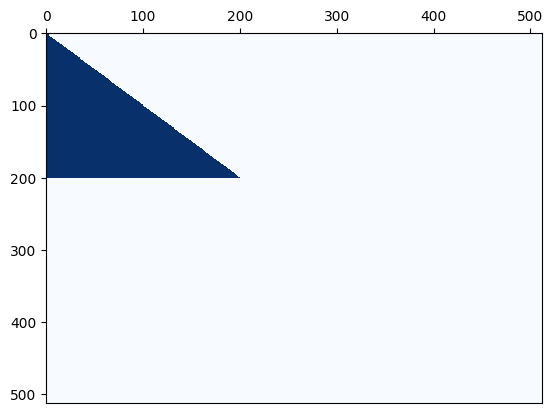

<Figure size 640x480 with 0 Axes>

In [74]:
draw_heatmap(create_masks(frame, phrase)[1])

In [71]:
create_masks(frame, phrase)[1][500, 500]

tensor(-1.0000e+09)